# Preprocess HCC mRNA data of Mondor series for heatmap

# Questions:
### Which genes to be used?
- All the genes in Mondor list (767 genes)
- Only those overlapping with Immune classifier in Sia's paper (33 genes)
- Overlapping genes + other genes


1. Clean FPKM genes:  (733, 340)
2. Reduced genes
    - Filter not expressed genes: FPKM < 0.1 for more than 0.85 samples.  (702, 340)
    - Filter low variance genes: 
        - std<0.5: (644, 340) From heatamp and consensus, better but not enough
        - std<1: (572, 340)
        - std<4: (331, 340). Sample K=5
        - std<6: (268, 340)

### What further data processing should we apply? 
#### Only process for each row (gene). -- A kind of bi-clustering
1. add 1 to the FPKM values
2. log transform the data
3. median centering or Z-Score
4. perform hc with your favourite distance and linkage methods (euclidean and wardD should be fine)
5. change the range of the gene values (each gene between 0 and 1 for instance) only for the heatmap visualisation

In [1]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# matplotlib 3.1.2 have a problem of cutting off the top and bottom boxes
# !conda install -c conda-forge matplotlib=3.1.2
import matplotlib
import matplotlib.pyplot as plt
# After seaborn 0.9.0, control the LineCollection properties of the dendrogram by using the tree_kws parameter
# !conda install -c conda-forge seaborn=0.10.0
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet, ward, average, complete, single
from matplotlib.patches import Rectangle
import csv

# Part Data

## Load and visualize data

In [29]:
# root = "E:\\deeplearning\\Hepatocarcinomes\\TCGA\\"
root = "/media/visiopharm5/WDGold/deeplearning/Hepatocarcinomes/TCGA"

In [30]:
# data_full = pd.read_csv(root + 'processed_backup\\fpkm_TCGA_CCL3L1.csv', sep=',', index_col=0)
# # gene_table = pd.read_csv(root + 'processed_backup\\gene_table_TCGA.csv', sep=',')
# # gene_sia = pd.read_excel(root + 'classifier_genes_Sia_UPPER.xlsx')
# nanostring = pd.read_csv(root + "ProbeAnnotations_NS_IO_360_v1.0_clean.csv", sep="\t")
# # Load real HCC sample list
# df_hcc = pd.read_excel(root + 'IDsTCGA.xlsx', sep='\t')
# # Load samples that have no mRNA
# df_no_mrna = pd.read_csv(root + "HCC_no_gene_expression.csv", sep='\t', header=None)
# # Load sample list with no slides
# df_no_slide = pd.read_csv(root + "HCC_no_slide.csv", sep='\t', header=None)

# Load mRNA data of Mondor series
data_full = pd.read_csv(os.path.join(root, 'data/nanostring_mondor/EX128_normadata_b08-b09_b10-060720-sans313.txt')
                       , sep = '\t')
# Load gene info
nanostring = pd.read_csv(os.path.join(root, "ProbeAnnotations_NS_IO_360_v1.0_clean.csv"), sep="\t")
# Load sample list not in ref
df_not_in_ref = pd.read_csv(os.path.join(root, 'data/HMN_HCC_mrna_not_in_ref.csv'))
# Load sample list with no slides
df_no_slide = pd.read_csv(os.path.join(root, 'data/HMN_HCC_no_slide.csv'))

In [31]:
# print("df data_full:")
# display(data_full.head(5))
# print(data_full.shape) # (754, 424), added CCL3L1
# # print()
# # print("df gene_table:")
# # display(gene_table.head(5))
# # print(gene_table.shape) # (753, 19)
# print()
# print(df_hcc.shape) # (358, 1)
# display(df_hcc.head(5))
# print()
# print(df_no_mrna.shape) # (6, 1)
# display(df_no_mrna.head(5))
# print()
# print(df_no_slide.shape) # (11, 1)
# display(df_no_slide.head(5))
# set_sample_no_slide = set(i[8:] for i in df_no_slide[0])

print("df data_full:")
display(data_full.head(5))
print(data_full.shape) # (786, 161)
print()
print(df_no_slide.shape) # (55, 3)
display(df_no_slide.head(5))
print(df_no_slide.shape)
print()
print(df_not_in_ref.shape) # (4, 1)
display(df_not_in_ref.head(5))

df data_full:


,Probe Name,Annotation,Class Name,EX128-ARN189,EX128-ARN190,EX128-ARN191,EX128-ARN192,EX128-ARN193,EX128-ARN194,EX128-ARN195,...,EX128-ARN338,EX128-ARN339,EX128-ARN340,EX128-ARN341,EX128-ARN342,EX128-ARN343,EX128-ARN344,EX128-ARN345,EX128-ARN346,EX128-ARN347
0,NaN,NaN,NaN,P743821,P734242,P719664,P701988,P701701,P699574,P699553,...,P622582,P621115,P619428,P613079,P607163,P606883,MAQC human,P606307,P605714,P605285
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A2M,NaN,Endogenous,4301.22,17983.246,15483.546,5113.288,4250.48,22340.941,7798.648,...,8090.045,10301.013,14885.443,40962.395,3889.948,18862.059,1442.44,6113.576,30052.156,19756.762
3,ACVR1C,NaN,Endogenous,35.049,20.447,34.268,157.602,206.357,99.563,39.143,...,82.297,92.323,239.394,40.155,86.482,53.972,3.636,21.423,120.063,29.988
4,ADAM12,NaN,Endogenous,9.6,111.335,1,2.646,1.291,8.33,7.946,...,2.08,29.2,3.53,19.692,4.129,5.168,110.465,8.054,11.779,5.56


(786, 161)

(55, 3)


,Unnamed: 0,Tumor_ID,Nanostring_id
0,8,HMNT2051,EX128-ARN020
1,9,HMNT0678,EX128-ARN024
2,12,HMNT1704,EX128-ARN032
3,16,HMNT1779,EX128-ARN040
4,17,HMNT1775,EX128-ARN042


(55, 3)

(4, 1)


,mrna_id
0,EX128-ARN195
1,EX128-ARN212
2,EX128-ARN209
3,EX128-ARN200


In [32]:
# print("df sia:")
# display(gene_sia.head(5))
# print(gene_sia.shape) # (112,3)
# print()
print("df nanostring:")
display(nanostring.head(5))
print(nanostring.shape) # (784, 12)

df nanostring:


,ProbeID,Codeset.Name,Probe.Label,Analyte.Type,Is.Control,Control.Type,Related.Probes,Probe.Annotation,KEGG.Pathways,Cell.Type,Official.Gene.Name,Control.Conc;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
0,NM_000077.4:1052,NS_IO_360_V1.0,CDKN2A,mRNA,False,NaN,NaN,Cell Proliferation;Metabolic Stress,hsa04110;hsa04115;hsa05166;hsa05200;hsa05203;h...,NaN,CDKN2A,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
1,NM_004120.4:1744,NS_IO_360_V1.0,GBP2,mRNA,False,NaN,NaN,Interferon Signaling,NaN,NaN,GBP2,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
2,NM_138636.4:2210,NS_IO_360_V1.0,TLR8,mRNA,False,NaN,NaN,Myeloid Compartment,hsa04620,NaN,TLR8,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
3,NM_001146055.1:480,NS_IO_360_V1.0,SNCA,mRNA,False,NaN,NaN,NaN,hsa05010;hsa05012,NaN,SNCA,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...
4,NM_001165.4:6567,NS_IO_360_V1.0,BIRC3,mRNA,False,NaN,NaN,Apoptosis;NF-kappaB Signaling,hsa04064;hsa04120;hsa04210;hsa04510;hsa04621;h...,NaN,BIRC3,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...


(784, 12)


## Preprocess
#### data_full: Gene Name (index), matrix / FPKM. 
#### NanoString Panel (784) - artificial genes (ERCC, 14) - CD34Rx (keep PTPRC, 3) - removed during normalization process (14) = 753

In [33]:
# Preprocessing specific for Mondor series
# Preprocess: remove row 0 and 1, remove column 1 and 2, and set the column 'Probe Name' as row index

data_full.drop(data_full.columns[[1, 2]], axis=1, inplace=True)
data_full.drop(data_full.index[[0, 1]], axis=0, inplace=True)
data_full.set_index('Probe Name', inplace=True)

print(data_full.shape) # (784, 158)
display(data_full.head(5))

(784, 158)


,EX128-ARN189,EX128-ARN190,EX128-ARN191,EX128-ARN192,EX128-ARN193,EX128-ARN194,EX128-ARN195,EX128-ARN196,EX128-ARN197,EX128-ARN198,...,EX128-ARN338,EX128-ARN339,EX128-ARN340,EX128-ARN341,EX128-ARN342,EX128-ARN343,EX128-ARN344,EX128-ARN345,EX128-ARN346,EX128-ARN347
Probe Name,,,,,,,,,,,,,,,,,,,,,
A2M,4301.22,17983.246,15483.546,5113.288,4250.48,22340.941,7798.648,4416.493,3322.068,6040.628,...,8090.045,10301.013,14885.443,40962.395,3889.948,18862.059,1442.44,6113.576,30052.156,19756.762
ACVR1C,35.049,20.447,34.268,157.602,206.357,99.563,39.143,393.982,125.555,8.607,...,82.297,92.323,239.394,40.155,86.482,53.972,3.636,21.423,120.063,29.988
ADAM12,9.6,111.335,1,2.646,1.291,8.33,7.946,2.7,24.751,1.884,...,2.08,29.2,3.53,19.692,4.129,5.168,110.465,8.054,11.779,5.56
ADGRE1,13.139,7.551,15.587,14.88,78.601,25.697,86.427,151.174,27.733,6.829,...,34.577,26.109,20.736,27.693,24.774,23.254,1,1,26.494,1
ADM,195.771,149.628,96.486,77.397,107.82,97.619,125.27,198.764,39.293,98.465,...,83.723,98.923,160.625,82.913,76.924,274.587,192.045,41.946,139.917,116.13


In [34]:
# Preprocessing 5 specific gene names for Mondor series
# Change the special gene names to the Official.Gene.Name
# CCL3/L1: CCL3L1, FCGR3A/B: FCGR3B, MAGEA3/A6: MAGEA3, TPSAB1/B2: TPSAB1, XCL1/2: XCL1
data_full = data_full.rename(index = {"CCL3/L1": "CCL3L1", "FCGR3A/B": "FCGR3B", "MAGEA3/A6": "MAGEA3", "TPSAB1/B2": "TPSAB1", 
                          "XCL1/2": "XCL1"})

In [35]:
# Name index as 'Gene Name'
data_full.index.name='Gene Name'
print(data_full.shape) # (754, 424) for TCGA, (784, 158) for Mondor
display(data_full.head(3))

(784, 158)


,EX128-ARN189,EX128-ARN190,EX128-ARN191,EX128-ARN192,EX128-ARN193,EX128-ARN194,EX128-ARN195,EX128-ARN196,EX128-ARN197,EX128-ARN198,...,EX128-ARN338,EX128-ARN339,EX128-ARN340,EX128-ARN341,EX128-ARN342,EX128-ARN343,EX128-ARN344,EX128-ARN345,EX128-ARN346,EX128-ARN347
Gene Name,,,,,,,,,,,,,,,,,,,,,
A2M,4301.22,17983.246,15483.546,5113.288,4250.48,22340.941,7798.648,4416.493,3322.068,6040.628,...,8090.045,10301.013,14885.443,40962.395,3889.948,18862.059,1442.44,6113.576,30052.156,19756.762
ACVR1C,35.049,20.447,34.268,157.602,206.357,99.563,39.143,393.982,125.555,8.607,...,82.297,92.323,239.394,40.155,86.482,53.972,3.636,21.423,120.063,29.988
ADAM12,9.6,111.335,1,2.646,1.291,8.33,7.946,2.7,24.751,1.884,...,2.08,29.2,3.53,19.692,4.129,5.168,110.465,8.054,11.779,5.56


### Drop an extra gene (CCL3): only for TCGA
#### Not included in NanoString but accidently included in FPKM

In [36]:
# # Only for TCGA
# data_full.drop("CCL3", inplace=True)
# print(data_full.shape) # (753, 424)

### Drop artificial genes: only for Mondor

In [37]:
list_art_genes = data_full.iloc[-14:].index.values.tolist()
print(len(list_art_genes)) # 14
print(list_art_genes) # 'NEG_A', 'NEG_B', 'NEG_C', 'NEG_D', 'NEG_E', 'NEG_F', 'NEG_G', 'NEG_H', 'POS_A', 'POS_B', 
                      # 'POS_C', 'POS_D', 'POS_E', 'POS_F'
    
data_full.drop(list_art_genes, inplace=True)
print(data_full.shape) # (770, 158)
display(data_full.head(3))

14
['NEG_A', 'NEG_B', 'NEG_C', 'NEG_D', 'NEG_E', 'NEG_F', 'NEG_G', 'NEG_H', 'POS_A', 'POS_B', 'POS_C', 'POS_D', 'POS_E', 'POS_F']
(770, 158)


,EX128-ARN189,EX128-ARN190,EX128-ARN191,EX128-ARN192,EX128-ARN193,EX128-ARN194,EX128-ARN195,EX128-ARN196,EX128-ARN197,EX128-ARN198,...,EX128-ARN338,EX128-ARN339,EX128-ARN340,EX128-ARN341,EX128-ARN342,EX128-ARN343,EX128-ARN344,EX128-ARN345,EX128-ARN346,EX128-ARN347
Gene Name,,,,,,,,,,,,,,,,,,,,,
A2M,4301.22,17983.246,15483.546,5113.288,4250.48,22340.941,7798.648,4416.493,3322.068,6040.628,...,8090.045,10301.013,14885.443,40962.395,3889.948,18862.059,1442.44,6113.576,30052.156,19756.762
ACVR1C,35.049,20.447,34.268,157.602,206.357,99.563,39.143,393.982,125.555,8.607,...,82.297,92.323,239.394,40.155,86.482,53.972,3.636,21.423,120.063,29.988
ADAM12,9.6,111.335,1,2.646,1.291,8.33,7.946,2.7,24.751,1.884,...,2.08,29.2,3.53,19.692,4.129,5.168,110.465,8.054,11.779,5.56


### Drop the 3 CD45s (keep PTPRC)

In [38]:
data_full.drop(['CD45RA', 'CD45RB','CD45RO'], inplace=True)
print(data_full.shape) # (767, 158)
display(data_full.head(3))

(767, 158)


,EX128-ARN189,EX128-ARN190,EX128-ARN191,EX128-ARN192,EX128-ARN193,EX128-ARN194,EX128-ARN195,EX128-ARN196,EX128-ARN197,EX128-ARN198,...,EX128-ARN338,EX128-ARN339,EX128-ARN340,EX128-ARN341,EX128-ARN342,EX128-ARN343,EX128-ARN344,EX128-ARN345,EX128-ARN346,EX128-ARN347
Gene Name,,,,,,,,,,,,,,,,,,,,,
A2M,4301.22,17983.246,15483.546,5113.288,4250.48,22340.941,7798.648,4416.493,3322.068,6040.628,...,8090.045,10301.013,14885.443,40962.395,3889.948,18862.059,1442.44,6113.576,30052.156,19756.762
ACVR1C,35.049,20.447,34.268,157.602,206.357,99.563,39.143,393.982,125.555,8.607,...,82.297,92.323,239.394,40.155,86.482,53.972,3.636,21.423,120.063,29.988
ADAM12,9.6,111.335,1,2.646,1.291,8.33,7.946,2.7,24.751,1.884,...,2.08,29.2,3.53,19.692,4.129,5.168,110.465,8.054,11.779,5.56


### Drop housekeeping genes
#### Drop 19 (1 missing) for TCGA, drop 20 for Mondor

In [39]:
name_hk = set(nanostring[nanostring["Control.Type"]=="Housekeeping"]["Probe.Label"].values) 
print("Number of housekeeping genes in NanoString:") # 20
print(str(len(name_hk)))
print("Housekeeping gene names:")
print(str(name_hk))
# {'SF3A1', 'SDHA', 'PUM1', 'GUSB', 'MRPL19', 'TBC1D10B', 'G6PD', 'TLK2', 'TMUB2', 'TBP', 'UBB', 'ABCF1', 'STK11IP'
# , 'TFRC', 'ERCC3', 'POLR2A', 'OAZ1', 'NRDE2', 'PSMC4', 'DNAJC14'}
print()
print("Missing housekeeping genes:")
print((name_hk - set(data_full.index))) # NRDE2 (aka. C14orf102) not found in the FPKM
name_hk = name_hk - ((name_hk - set(data_full.index)))
# data_full was updated but gene_table didn't
# print((name_hk - set(gene_table["gene_name"]))) # NRDE2 (aka. C14orf102) not found in the FPKM, found in Mondor
# name_hk = name_hk - ((name_hk - set(gene_table["gene_name"])))
print("Number of housekeeping genes to be dropped:")
print(str(len(name_hk))) # 19 for TCGA, 20 for Mondor

Number of housekeeping genes in NanoString:
20
Housekeeping gene names:
{'GUSB', 'G6PD', 'UBB', 'NRDE2', 'SF3A1', 'MRPL19', 'ERCC3', 'DNAJC14', 'TLK2', 'PUM1', 'TBP', 'SDHA', 'PSMC4', 'OAZ1', 'STK11IP', 'TMUB2', 'ABCF1', 'POLR2A', 'TFRC', 'TBC1D10B'}

Missing housekeeping genes:
set()
Number of housekeeping genes to be dropped:
20


In [40]:
data_full.drop(name_hk, inplace=True)
print(data_full.shape) # (734, 424) for TCGA, (747, 158) in Mondor
display(data_full.head(5))

(747, 158)


,EX128-ARN189,EX128-ARN190,EX128-ARN191,EX128-ARN192,EX128-ARN193,EX128-ARN194,EX128-ARN195,EX128-ARN196,EX128-ARN197,EX128-ARN198,...,EX128-ARN338,EX128-ARN339,EX128-ARN340,EX128-ARN341,EX128-ARN342,EX128-ARN343,EX128-ARN344,EX128-ARN345,EX128-ARN346,EX128-ARN347
Gene Name,,,,,,,,,,,,,,,,,,,,,
A2M,4301.22,17983.246,15483.546,5113.288,4250.48,22340.941,7798.648,4416.493,3322.068,6040.628,...,8090.045,10301.013,14885.443,40962.395,3889.948,18862.059,1442.44,6113.576,30052.156,19756.762
ACVR1C,35.049,20.447,34.268,157.602,206.357,99.563,39.143,393.982,125.555,8.607,...,82.297,92.323,239.394,40.155,86.482,53.972,3.636,21.423,120.063,29.988
ADAM12,9.6,111.335,1,2.646,1.291,8.33,7.946,2.7,24.751,1.884,...,2.08,29.2,3.53,19.692,4.129,5.168,110.465,8.054,11.779,5.56
ADGRE1,13.139,7.551,15.587,14.88,78.601,25.697,86.427,151.174,27.733,6.829,...,34.577,26.109,20.736,27.693,24.774,23.254,1,1,26.494,1
ADM,195.771,149.628,96.486,77.397,107.82,97.619,125.27,198.764,39.293,98.465,...,83.723,98.923,160.625,82.913,76.924,274.587,192.045,41.946,139.917,116.13


### Filter samples by 2 conditions: only for TCGA
1. Real HCCs
2. Have related slides

#### Filter real HCC samples: only for TCGA

In [14]:
# # Check duplicates: only for TCGA
# print("Duplicates:")
# display(df_hcc[df_hcc.ID.duplicated(keep=False)])

In [15]:
# # Only for TCGA
# set_samples_hcc = set(i[8:] for i in df_hcc.ID) # Items in FPKM have no "TCGA-XX-"
# print("Number of real HCC samples:")
# print(len(set_samples_hcc))

In [16]:
# # drop not HCC samples: only for TCGA
# print(data_full.shape) # (734, 424)
# dfObj = pd.DataFrame()
# for sampleid in set_samples_hcc:
#     dfObj = pd.concat([dfObj,data_full.loc[:, data_full.columns.str.startswith(sampleid)]], axis=1)
# data_full = dfObj
# del(dfObj)
# print(data_full.shape) # (734, 351)
# display(data_full.head(5))

#### Validate not include the 6 samples without mRNA

In [17]:
# # Validate no overlapping with samples that have no mRNA: only for TCGA
# set_sample_no_mrna = set(i[8:] for i in df_no_mrna[0])
# print(len(set(i[:-1] for i in data_full.columns.values).intersection(set_sample_no_mrna))) # 0
# del(df_no_mrna,set_sample_no_mrna)

In [18]:
# # For TCGA
# # drop no slide samples
# print(data_full.shape) # (734, 351) for TCGA, (764, 158)
# unwanted_sample=[]
# for sampleid in set_sample_no_slide:
#     unwanted_sample.append(data_full.columns[data_full.columns.str.startswith(sampleid)].values[0])
# data_full.drop(unwanted_sample, axis=1, inplace=True)
# print(data_full.shape) # (734, 340) for TCGA, 
# del(df_no_slide, set_sample_no_slide, unwanted_sample)

### Filter samples: only for Mondor
#### Drop 2 MAQC human and 1 H2O
#### Drop samples not in the ref
#### Drop samples without related slides

In [41]:
# For Mondor
data_full.drop(columns=["EX128-ARN271", "EX128-ARN272", "EX128-ARN344"], inplace=True) 
print(data_full.shape) # (747, 155) for Mondor 

(747, 155)


In [20]:
# For Mondor
print(data_full.shape) # (747, 155) for Mondor

# drop columns not in the ref
data_full.drop(df_not_in_ref['mrna_id'].values.tolist(), axis=1, inplace=True)
print(data_full.shape) # (747, 151) for Mondor

# drop no slide samples
data_full.drop(df_no_slide['Nanostring_id'].values.tolist(), axis=1, errors='ignore', inplace=True)
print(data_full.shape) # (747, 139) for Mondor 

del(df_no_slide, df_not_in_ref)

(747, 155)
(747, 151)
(747, 139)


## Count missing values

In [42]:
# Only for Mondor
data_full = data_full.apply(pd.to_numeric)

In [43]:
# Missing elements
print("Number of NaN or missing data: " + str(data_full.isnull().sum().sum())) # 0, should not be any missing data
print("Number of 0: " + str((data_full==0.0000).sum().sum())) # for TCGA, 10428, 0 doesn't mean missing; 0 for Mondor

Number of NaN or missing data: 0
Number of 0: 0


In [44]:
# Missing names of row or col
print("Missing values in gene name: " + str(data_full.index.isna().sum())) # 0 
print("Missing values in sample id: " + str(data_full.columns.isna().sum())) # 0

Missing values in gene name: 0
Missing values in sample id: 0


In [45]:
# How many all-NA rows and their indices
print("All-zero rows: " + str(((data_full.T==0.0000).sum()==139).sum())) # TCGA, 1, normal. Not expressed at all. 0 for Mondor
display(data_full.iloc[np.where((data_full.T==0.0000).sum()==139)]) # also all-zero in fpkm_TCGA (DEFB134) for TCGA, empty for Mondor
print("All-zero cols: " + str(((data_full==0.0000).sum()==747).sum())) # 0

All-zero rows: 0


,EX128-ARN189,EX128-ARN190,EX128-ARN191,EX128-ARN192,EX128-ARN193,EX128-ARN194,EX128-ARN195,EX128-ARN196,EX128-ARN197,EX128-ARN198,...,EX128-ARN337,EX128-ARN338,EX128-ARN339,EX128-ARN340,EX128-ARN341,EX128-ARN342,EX128-ARN343,EX128-ARN345,EX128-ARN346,EX128-ARN347
Gene Name,,,,,,,,,,,,,,,,,,,,,


All-zero cols: 0


In [59]:
# # Only for TCGA, remove the all-zero (not expressed) gene, otherwise there will be problem when performing Z-Score and scaling
# data_full.drop(labels='DEFB134', inplace=True)
# data_full.shape

In [60]:
display(data_full.T.describe())
print("Minimum of the data: "+str(data_full.min().min())) # 0 for TCGA, 1 for Mondor

Gene Name,A2M,ACVR1C,ADAM12,ADGRE1,ADM,ADORA2A,AKT1,ALDOA,ALDOC,ANGPT1,...,WNT3A,WNT4,WNT5A,WNT5B,WNT7B,XCL1,ZAP70,ZC3H12A,ZEB1,ZEB2
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,...,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,15834.273355,56.092490,20.076923,24.164800,109.232619,57.482097,1006.177006,1896.064729,334.306981,130.106568,...,39.244355,43.705987,157.212065,92.060981,13.571052,45.926413,68.749987,78.601877,206.041826,292.826574
std,11514.188311,70.287341,37.380361,31.725623,94.758399,41.914774,323.041338,1291.280670,349.789050,100.381388,...,78.604255,58.202786,150.379347,109.527461,21.850278,45.542915,53.647242,80.043812,98.554182,161.392186
min,472.476000,1.000000,1.000000,1.000000,7.703000,3.429000,368.698000,377.094000,9.904000,5.565000,...,1.000000,1.000000,2.057000,1.000000,1.000000,1.475000,6.315000,6.531000,15.994000,37.307000
25%,6440.542500,10.369000,2.462000,4.395000,53.275500,29.304500,770.826000,1146.707000,124.124000,65.739500,...,2.007500,11.353000,56.868000,23.102000,1.787000,16.482500,28.345000,34.127000,146.029000,159.571500
50%,14173.418000,26.344000,8.389000,13.139000,88.287000,44.808000,980.509000,1603.095000,217.367000,104.610000,...,9.294000,25.073000,118.934000,54.740000,5.612000,33.155000,51.213000,55.871000,190.319000,268.212000
75%,22386.278000,79.115000,22.458000,28.113500,128.473000,75.312500,1218.002500,2177.628500,450.183500,148.401000,...,42.510000,53.202000,205.755500,118.044000,15.134000,60.084500,89.853000,93.723000,237.194000,396.805000
max,51707.938000,393.982000,322.650000,185.226000,645.408000,244.277000,2025.454000,9282.062000,2941.834000,543.279000,...,532.471000,427.800000,751.104000,725.589000,163.687000,325.156000,245.706000,560.071000,819.418000,979.291000


Minimum of the data: 1.0


In [61]:
print("max: " + str(data_full.max().max())) # 51296.766629443606 for TCGA, 259955.984 for Mondor
print("min: " + str(data_full.min().min())) # 0.0 for TCGA, 1.0 for Mondor
print("mean: " + str(data_full.sum().sum()/data_full.shape[0]/data_full.shape[1])) # 78.63050983824839 for TCGA, 594.8548331744244 for Mondor

max: 259955.984
min: 1.0
mean: 585.5812838450576


## Export processed data

In [25]:
# data_full.to_csv(root + 'processed\\fpkm_final_raw_CCL3L1.csv', index=True, sep='\t')

data_full.to_csv(os.path.join(root, "heatmap_nanostring_139/mondor_final_raw_min1.csv"), index=True, sep='\t')

In [63]:
display(data_full.T.describe())

Gene Name,A2M,ACVR1C,ADAM12,ADGRE1,ADM,ADORA2A,AKT1,ALDOA,ALDOC,ANGPT1,...,WNT3A,WNT4,WNT5A,WNT5B,WNT7B,XCL1,ZAP70,ZC3H12A,ZEB1,ZEB2
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,...,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,15834.273355,56.092490,20.076923,24.164800,109.232619,57.482097,1006.177006,1896.064729,334.306981,130.106568,...,39.244355,43.705987,157.212065,92.060981,13.571052,45.926413,68.749987,78.601877,206.041826,292.826574
std,11514.188311,70.287341,37.380361,31.725623,94.758399,41.914774,323.041338,1291.280670,349.789050,100.381388,...,78.604255,58.202786,150.379347,109.527461,21.850278,45.542915,53.647242,80.043812,98.554182,161.392186
min,472.476000,1.000000,1.000000,1.000000,7.703000,3.429000,368.698000,377.094000,9.904000,5.565000,...,1.000000,1.000000,2.057000,1.000000,1.000000,1.475000,6.315000,6.531000,15.994000,37.307000
25%,6440.542500,10.369000,2.462000,4.395000,53.275500,29.304500,770.826000,1146.707000,124.124000,65.739500,...,2.007500,11.353000,56.868000,23.102000,1.787000,16.482500,28.345000,34.127000,146.029000,159.571500
50%,14173.418000,26.344000,8.389000,13.139000,88.287000,44.808000,980.509000,1603.095000,217.367000,104.610000,...,9.294000,25.073000,118.934000,54.740000,5.612000,33.155000,51.213000,55.871000,190.319000,268.212000
75%,22386.278000,79.115000,22.458000,28.113500,128.473000,75.312500,1218.002500,2177.628500,450.183500,148.401000,...,42.510000,53.202000,205.755500,118.044000,15.134000,60.084500,89.853000,93.723000,237.194000,396.805000
max,51707.938000,393.982000,322.650000,185.226000,645.408000,244.277000,2025.454000,9282.062000,2941.834000,543.279000,...,532.471000,427.800000,751.104000,725.589000,163.687000,325.156000,245.706000,560.071000,819.418000,979.291000


In [64]:
data_full.shape # (747, 139)

(747, 155)

In [65]:
def drop_not_expressed_genes(df, fname, threshold = 0.1, percentage = 0.85):
    genes_not_expressed = []
    df = df.copy(deep = True)
    for index, row in df.iterrows():
        if((np.array(row) < threshold).sum() > df.shape[1] * percentage):
            genes_not_expressed.append(index)
            df.drop(index, inplace=True)
    print(len(genes_not_expressed)) # 31 for TCGA, 0 for Mondor
    print(genes_not_expressed)
    #['CCL7', 'CCNA1', 'CEACAM3', 'COL17A1', 'CSF2', 'CSF3', 'FCAR', 'FCRL2', 'FGF9', 'IFNA1', 'IL11', 'IL17A', 
    # 'IL1A', 'IL24', 'IL2', 'IL4', 'KIR2DL3', 'KIR3DL1', 'KIR3DL2', 'LAMA1', 'LILRA1', 'MAGEA4', 'MLANA', 'NCR1',
    # 'PPARGC1B', 'SERPINB5', 'SOX10', 'SOX11', 'TNFSF18', 'WNT2B', 'WNT7B']
    with open(fname, 'w') as myfile:
         wr = csv.writer(myfile, quoting=csv.QUOTE_ALL, delimiter="\n")
         wr.writerow(genes_not_expressed)
    del(genes_not_expressed)
    print(df.shape) # (702, 340) for TCGA, (747, 128) for Mondor
    
    return df

# data_expressed = drop_not_expressed_genes(data_full, fname = root + "processed\\fpkm_removed_not_expressed_genes.csv")
    
data_expressed = drop_not_expressed_genes(data_full, threshold=1.1, fname = os.path.join(root, "heatmap_nanostring/mondor_removed_not_expressed_genes.csv"))

0
[]
(747, 155)


In [26]:
display(data_expressed.T.describe())

Gene Name,A2M,ACVR1C,ADAM12,ADGRE1,ADM,ADORA2A,AKT1,ALDOA,ALDOC,ANGPT1,...,WNT3A,WNT4,WNT5A,WNT5B,WNT7B,XCL1,ZAP70,ZC3H12A,ZEB1,ZEB2
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,15908.258971,54.377273,18.897504,23.196353,109.499741,57.445971,1024.485619,1872.333180,335.805842,129.735748,...,38.915504,44.064813,163.657288,91.936388,13.464698,44.428345,68.981576,79.977475,206.042928,296.670518
std,11786.525400,71.005938,29.346599,31.756676,98.199389,42.199508,327.221305,1292.660827,362.198277,103.099963,...,80.788628,60.305941,154.777888,112.225960,22.722554,46.337061,53.358441,82.148275,100.783642,163.298120
min,472.476000,1.000000,1.000000,1.000000,7.703000,3.429000,368.698000,486.292000,9.904000,5.565000,...,1.000000,1.000000,2.057000,1.000000,1.000000,1.475000,6.315000,6.531000,15.994000,37.307000
25%,6158.547000,10.369000,2.516000,4.225000,53.275500,31.734000,779.786000,1146.707000,119.657500,64.893500,...,1.932500,11.353000,62.274000,23.975500,1.787000,15.910500,29.169500,35.489000,143.314000,159.571500
50%,13624.493000,24.765000,8.849000,9.400000,83.723000,45.726000,999.319000,1598.936000,216.552000,101.081000,...,8.690000,24.800000,120.007000,52.008000,4.975000,33.058000,51.213000,55.933000,189.189000,274.199000
75%,21862.096500,72.694000,22.458000,27.268500,130.063000,71.557500,1234.293000,2107.899000,457.575500,148.401000,...,42.510000,51.568500,208.432500,117.046500,14.558000,56.071500,89.853000,94.884000,241.083000,398.527500
max,51707.938000,393.982000,216.221000,185.226000,645.408000,244.277000,2025.454000,9282.062000,2941.834000,543.279000,...,532.471000,427.800000,751.104000,725.589000,163.687000,325.156000,245.706000,560.071000,819.418000,979.291000


In [27]:
# Statistics for std, will be the same as without + 1
gene_std = data_expressed.T.std()
print("max: " + str(max(gene_std))) # 5140.104029061708 for TCGA, 48828.703810738065 for Mondor
print("min: " + str(min(gene_std))) # 0.11951520260599444 for TCGA, 2.201875516820929 for Mondor
print("mean: " + str(sum(gene_std)/len(gene_std))) # 42.618529287045 for TCGA, 518.480639745944 for Mondor

max: 48828.703810738065
min: 2.201875516820929
mean: 518.480639745944


In [83]:
# Plot barplot for std
# plt.figure(figsize=(20,4))
# plt.xscale('log') # base = 10
# sns.distplot(gene_std, bins=50000, kde=False, norm_hist=True)

In [28]:
print("Percentage of std<0.5: " + str((np.array(gene_std)<0.5).sum()/len(gene_std))) # 0.0811965811965812 for TCGA, 0.0 for Mondor
print("Percentage of std<1: " + str((np.array(gene_std)<1).sum()/len(gene_std))) # 0.18518518518518517 for TCGA, 0.0 for Mondor
print("Percentage of std<4: " + str((np.array(gene_std)<4).sum()/len(gene_std))) # 0.5284900284900285 for TCGA, 0.0013386880856760374 for Mondor
print("Percentage of std<6: " + str((np.array(gene_std)<6).sum()/len(gene_std))) # 0.6182336182336182 for TCGA, 0.008032128514056224 for Mondor

Percentage of std<0.5: 0.0
Percentage of std<1: 0.0
Percentage of std<4: 0.0013386880856760374
Percentage of std<6: 0.008032128514056224


In [85]:
# Check std of specific genes
glist = ["MAGEA1", "MAGEC2", "MAGEA12", "MAGEA3", "CTAG1B", "MAGEB2", "FCGR2B", "FCGR3B", "CXCL13", "FOXP3", "LAMB3"]
for g in glist:
    print(data_expressed.loc[g].std())

9.216820078105064
10.538506257591884
6.7677116283315035
10.588266308530065
9.05364135223048
5.59861644440679
4.09353723459655
8.279802149712031
18.501344199721498
4.269170344419321
10.864826753927625


In [29]:
def filter_genes(df=data_full, theshold=0):
    genes_removed = []
    data_filtered = df.copy(deep = True)
    for index, row in data_filtered.iterrows():
        if(np.array(row).std()<theshold):
            genes_removed.append(index)
            data_filtered.drop(index, inplace=True)
    print(len(genes_removed))
    print(genes_removed) # exclude the not expressed genes
    data_removed = data_full.filter(pd.DataFrame(data_full.filter(genes_removed, axis=0).T.std(), columns=["std"])
                                    .sort_values(by="std", ascending=False).index, axis=0)
#     with open(root + "processed\\fpkm_filtered_std-{0}_genes.csv".format(str(theshold)), 'w') as myfile:
#          wr = csv.writer(myfile, quoting=csv.QUOTE_ALL, delimiter="\n")
#          wr.writerow(genes_romved)
    print(data_filtered.shape) # (702, 340)
    return data_filtered, data_removed

In [30]:
# pd.DataFrame(data_expressed.filter(genes_filtered-4, axis=0).T.std(), columns=["std"]).sort_values(by="std", ascending=False)

In [31]:
data_filtered_05, data_removed_05 = filter_genes(data_expressed, theshold=0.5) # 0
data_filtered_1, data_removed_1 = filter_genes(data_expressed, theshold=1) # 0
data_filtered_4, data_removed_4 = filter_genes(data_expressed, theshold=4) # 1
data_filtered_6, data_removed_6 = filter_genes(data_expressed, theshold=6) # 6

0
[]
(747, 139)
0
[]
(747, 139)
1
['TWIST2']
(746, 139)
6
['BLK', 'COL17A1', 'IL21R', 'MS4A2', 'RIPK3', 'TWIST2']
(741, 139)


In [32]:
print(data_full.shape) # (747, 139)
print(data_filtered_05.shape) # (747, 139)
print(data_filtered_1.shape) # (747, 139)
print(data_filtered_4.shape) # (746, 139)
print(data_filtered_6.shape) # (741, 139)

(747, 139)
(747, 139)
(747, 139)
(746, 139)
(741, 139)


In [32]:
# Export filtered data
data_filtered_4.to_csv(os.path.join(root, 'heatmap_nanostring/mondor_filtered-4_raw_min1.csv'), index=True, sep='\t')
data_full.to_csv(os.path.join(root, 'heatmap_nanostring/mondor_full_raw_min1.csv'), index=True, sep='\t')

#### Check if all the Sia and Sangro genes are included

In [33]:
print(data_full.shape)
display(data_full.head(5))

(747, 139)


,EX128-ARN190,EX128-ARN192,EX128-ARN193,EX128-ARN194,EX128-ARN196,EX128-ARN197,EX128-ARN198,EX128-ARN199,EX128-ARN201,EX128-ARN202,...,EX128-ARN337,EX128-ARN338,EX128-ARN339,EX128-ARN340,EX128-ARN341,EX128-ARN342,EX128-ARN343,EX128-ARN345,EX128-ARN346,EX128-ARN347
Gene Name,,,,,,,,,,,,,,,,,,,,,
A2M,17983.246,5113.288,4250.480,22340.941,4416.493,3322.068,6040.628,4480.220,15580.017,18190.949,...,2305.100,8090.045,10301.013,14885.443,40962.395,3889.948,18862.059,6113.576,30052.156,19756.762
ACVR1C,20.447,157.602,206.357,99.563,393.982,125.555,8.607,24.352,79.542,16.399,...,126.000,82.297,92.323,239.394,40.155,86.482,53.972,21.423,120.063,29.988
ADAM12,111.335,2.646,1.291,8.330,2.700,24.751,1.884,7.556,21.438,24.095,...,1.295,2.080,29.200,3.530,19.692,4.129,5.168,8.054,11.779,5.560
ADGRE1,7.551,14.880,78.601,25.697,151.174,27.733,6.829,8.623,27.581,9.364,...,53.568,34.577,26.109,20.736,27.693,24.774,23.254,1.000,26.494,1.000
ADM,149.628,77.397,107.820,97.619,198.764,39.293,98.465,147.513,167.160,110.385,...,73.804,83.723,98.923,160.625,82.913,76.924,274.587,41.946,139.917,116.130


In [92]:
gene_sangro = pd.read_csv(root + 'processed\\Sangro_Table2_GeneList.csv', sep=',', header=None, names=["Gene name"])
gene_sangro[gene_sangro["Gene name"] == "CD274(PDL1)"] = "CD274"
gene_sia = pd.read_excel(root + 'classifier_genes_Sia_UPPER.xlsx', usecols=[1])

In [93]:
print("Gene Sangro:")
print(gene_sangro.shape)
display(gene_sangro.head(5))
print("Gene Sia:")
print(gene_sia.shape)
display(gene_sia.head(5))

Gene Sangro:
(29, 1)


,Gene name
0,CD274
1,CD8A
2,LAG3
3,STAT1
4,CCL2


Gene Sia:
(112, 1)


,Gene name
0,PAGE4
1,UGT2B17
2,C1QTNF3
3,DHRS2
4,FAM133A


In [94]:
# Overlapping genes with Sangro's list
set_gene_full = set(data_full.index)
set_gene_sangro = set(gene_sangro["Gene name"])
set_gene_sangro = set_gene_full.intersection(set_gene_sangro)
print(len(set_gene_sangro))
print(set_gene_sangro)

28
{'IRF1', 'HLA-DMB', 'CCL5', 'GZMK', 'GZMA', 'CD276', 'ICOS', 'CCR5', 'CCL4', 'CXCL11', 'IFNG', 'HLA-DMA', 'CD27', 'PRF1', 'CXCR6', 'HLA-DRA', 'TIGIT', 'CD8A', 'CD274', 'LAG3', 'STAT1', 'CXCL10', 'HLA-DOA', 'PDCD1LG2', 'CXCL9', 'IDO1', 'CCL2', 'HLA-DOB'}


In [95]:
# Overlapping genes with Sia's list
set_gene_sia = set(gene_sia["Gene name"])
set_gene_sia = set_gene_full.intersection(set_gene_sia)
print(len(set_gene_sia))
print(set_gene_sia)

33
{'CD3D', 'CXCL14', 'HLA-DRB5', 'CCL19', 'CCL18', 'PTPRC', 'LTB', 'MMP7', 'CCL5', 'GZMK', 'GZMA', 'SAMSN1', 'COL6A3', 'CCL4', 'CXCL6', 'GZMH', 'CD38', 'MS4A1', 'CD2', 'CD27', 'DUSP2', 'CCL21', 'ID4', 'CD8A', 'CD48', 'CXCR4', 'MMP9', 'IL7R', 'GZMB', 'ITGB2', 'C7', 'CXCL9', 'CCL2'}


In [96]:
print(len(set_gene_sangro.intersection(set_gene_sia)))
print(set_gene_sangro.intersection(set_gene_sia))

8
{'CD27', 'CCL4', 'CXCL9', 'CCL5', 'CCL2', 'GZMK', 'GZMA', 'CD8A'}


In [97]:
print(len(set(data_filtered_6.index).intersection(set_gene_sangro)))
print(len(set(data_filtered_6.index).intersection(set_gene_sia)))

12
20


In [98]:
print(set_gene_sangro-set(data_filtered_6.index))
print(set_gene_sia-set(data_filtered_6.index))

{'ICOS', 'HLA-DOA', 'PRF1', 'CXCR6', 'CCR5', 'TIGIT', 'CCL4', 'PDCD1LG2', 'HLA-DOB', 'CXCL11', 'IFNG', 'GZMK', 'IDO1', 'CD8A', 'CD274', 'LAG3'}
{'SAMSN1', 'COL6A3', 'IL7R', 'GZMB', 'PTPRC', 'DUSP2', 'ID4', 'CCL4', 'CD38', 'GZMK', 'MS4A1', 'CD8A', 'CD48'}


#### data_sia: Gene Name (index), FPKM. Only genes overlap with Immune classifier in Sia's paper.

In [99]:
# subset data sia and export
data_sia = data_full.filter(items=list(set_gene_sia),axis=0)
print(data_sia.shape)
display(data_sia.head(5))

(33, 340)


,A3CH-01A,AAV2-01A,AACJ-01A,A3CI-01A,A9H2-01A,A1ED-01A,AADW-01A,A4ND-01A,A25X-01A,A7MB-01A,...,A75V-01A,A86L-01A,A9FV-01A,A216-01A,A9H8-01A,AADS-01A,A9GS-01A,A8TG-01A,A5KG-01A,AAV0-01A
Gene Name,,,,,,,,,,,,,,,,,,,,,
CD3D,1.994967,0.221795,0.332366,2.233219,1.315703,2.639995,0.713847,3.435745,14.655037,0.288343,...,4.246886,1.911618,4.854942,6.598238,10.944255,51.345138,1.106445,0.653652,35.451545,5.841820
CXCL14,0.715443,0.000000,0.000000,0.219290,1.427483,2.117992,0.056601,2.184642,0.200008,0.000000,...,0.195081,0.116601,0.099061,1.458713,0.011141,0.064364,0.035790,0.052601,29.197706,0.585108
HLA-DRB5,15.316467,12.773488,2.717870,87.336069,30.831746,85.879471,4.249916,9.941538,30.381893,0.850384,...,162.174148,3.382654,49.478456,17.022556,59.133588,606.313723,10.317268,32.959915,122.752593,13.836826
CCL19,17.552189,0.058930,0.000000,9.345317,0.667820,5.171192,3.278370,5.444852,0.199319,0.014989,...,17.707334,0.510894,0.175900,0.177614,0.932640,1.632699,3.423958,4.784442,734.036092,8.643469
CCL18,1.672728,2.556542,0.100465,1.670718,0.544773,1.382058,0.257317,5.420912,1.300078,0.166737,...,0.945377,0.373888,10.300513,0.345756,5.250141,5.720992,3.981880,0.869353,7.005188,0.728398


In [5]:
# sia genes existing in Mondor list
set1 = set(gene_sia["ID name"])
set2 = set(firehose["Gene Name"]).union(set(firehose["Official.Gene.Name"]).union(set(firehose["Probe.Label"])))
set_gene_sia = set1.intersection(set2)
print(len(set_gene_sia))
print(set_gene_sia)

33
{'CD8A', 'DUSP2', 'CXCL9', 'CD48', 'CCL21', 'MS4A1', 'MMP9', 'CCL18', 'GZMA', 'GZMB', 'CXCL6', 'CCL4', 'LTB', 'C7', 'IL7R', 'GZMK', 'CXCL14', 'CD2', 'MMP7', 'CD38', 'COL6A3', 'CD3D', 'CCL2', 'GZMH', 'CCL5', 'CD27', 'PTPRC', 'SAMSN1', 'HLA-DRB5', 'ID4', 'ITGB2', 'CXCR4', 'CCL19'}


In [6]:
# # Filter the data related to siz genes by names
# data_sia = pd.DataFrame(columns=firehose.columns)
# for name in set_gene_sia:
#     for column in ["Gene Name", "Official.Gene.Name", "Probe.Label"]:
#             data_sia = pd.concat([data_sia, firehose[firehose[column]==name]])
# data_sia.drop_duplicates(inplace=True)

# print(data_sia.shape)
# display(data_sia.head(5))

(33, 360)


,"(Gene name, RefSeq mRNA ID)",Gene ID,Gene Name,Hybridization REF,Official.Gene.Name,Probe.Label,ProbeID,TCGA-2V-A95S-01A-11R-A37K-07 normalized_count,TCGA-2Y-A9GS-01A-12R-A38B-07 normalized_count,TCGA-2Y-A9GT-01A-11R-A38B-07 normalized_count,...,TCGA-ZP-A9CZ-01A-11R-A38B-07 normalized_count,TCGA-ZP-A9D0-01A-11R-A37K-07 normalized_count,TCGA-ZP-A9D1-01A-11R-A38B-07 normalized_count,TCGA-ZP-A9D4-01A-11R-A37K-07 normalized_count,TCGA-ZS-A9CD-01A-11R-A37K-07 normalized_count,TCGA-ZS-A9CE-01A-11R-A37K-07 normalized_count,TCGA-ZS-A9CF-01A-11R-A38B-07 normalized_count,TCGA-ZS-A9CG-01A-11R-A37K-07 normalized_count,TCGA-DD-AACA-02B-11R-A41C-07 normalized_count,TCGA-ZS-A9CF-02A-11R-A38B-07 normalized_count
201,CD8A|NM_001768,925,CD8A,CD8A|925,CD8A,CD8A,NM_001768,1702.5574,34.4998,936.1130,...,220.3942,17.3745,104.1801,25.4561,54.0947,7.1116,62.7154,45.2442,14.3086,57.4784
436,DUSP2|NM_004418,1844,DUSP2,DUSP2|1844,DUSP2,DUSP2,NM_004418,600.0977,17.7427,313.8310,...,99.3326,54.6976,28.2958,10.1824,89.4065,4.9234,146.7953,34.9614,8.3878,28.4302
689,CXCL9|NM_002416,4283,CXCL9,CXCL9|4283,CXCL9,CXCL9,NM_002416,14417.9834,827.0084,4564.8958,...,1676.8586,212.3552,97.1061,716.1646,365.1390,263.6761,778.7733,261.1825,44.4061,385.0433
405,CD48|NM_001778,962,CD48,CD48|962,CD48,CD48,NM_001778,700.4398,166.5845,391.8404,...,282.4771,53.4106,183.2797,40.7297,121.7130,4.9234,104.7553,80.2057,24.1766,97.6514
230,CCL21|NM_002989,6366,CCL21,CCL21|6366,CCL21,CCL21,NM_002989,277.5696,152.2918,938.8030,...,762.9986,77.2201,722.1865,27.7189,1113.4485,6.0175,24.1213,124.7644,1.9736,279.9753


In [7]:
# # Keep only the gene names (as index) and counts
# data_sia.drop(["(Gene name, RefSeq mRNA ID)", "Gene ID", "Hybridization REF", "Official.Gene.Name", "Probe.Label", "ProbeID"], 1, inplace=True)
# data_sia.set_index("Gene Name", inplace=True)
# data_sia.columns = [ncol[:-17] for ncol in data_sia.columns]
# print(data_sia.shape)
# display(data_sia.head(3))

(33, 353)


,TCGA-2V-A95S-01A-11R-A37K-07,TCGA-2Y-A9GS-01A-12R-A38B-07,TCGA-2Y-A9GT-01A-11R-A38B-07,TCGA-2Y-A9GU-01A-11R-A38B-07,TCGA-2Y-A9GV-01A-11R-A38B-07,TCGA-2Y-A9GW-01A-11R-A38B-07,TCGA-2Y-A9GX-01A-11R-A38B-07,TCGA-2Y-A9GY-01A-11R-A38B-07,TCGA-2Y-A9GZ-01A-11R-A39D-07,TCGA-2Y-A9H0-01A-11R-A38B-07,...,TCGA-ZP-A9CZ-01A-11R-A38B-07,TCGA-ZP-A9D0-01A-11R-A37K-07,TCGA-ZP-A9D1-01A-11R-A38B-07,TCGA-ZP-A9D4-01A-11R-A37K-07,TCGA-ZS-A9CD-01A-11R-A37K-07,TCGA-ZS-A9CE-01A-11R-A37K-07,TCGA-ZS-A9CF-01A-11R-A38B-07,TCGA-ZS-A9CG-01A-11R-A37K-07,TCGA-DD-AACA-02B-11R-A41C-07,TCGA-ZS-A9CF-02A-11R-A38B-07
Gene Name,,,,,,,,,,,,,,,,,,,,,
CD8A,1702.5574,34.4998,936.1130,75.9067,62.6058,36.7816,416.9697,827.5308,18.4300,643.1029,...,220.3942,17.3745,104.1801,25.4561,54.0947,7.1116,62.7154,45.2442,14.3086,57.4784
DUSP2,600.0977,17.7427,313.8310,19.1852,69.3739,71.2644,109.0909,317.6219,9.5563,157.0222,...,99.3326,54.6976,28.2958,10.1824,89.4065,4.9234,146.7953,34.9614,8.3878,28.4302
CXCL9,14417.9834,827.0084,4564.8958,236.8957,217.4281,963.2184,1765.4545,3872.5228,75.0853,860.8070,...,1676.8586,212.3552,97.1061,716.1646,365.1390,263.6761,778.7733,261.1825,44.4061,385.0433


In [8]:
# print("Number of 0 or missing data: " + str((data_sia==0.0000).sum().sum()))

Number of 0 or missing data: 253


#### Covriance matrix

In [22]:
# covMatrix_full = np.cov(data_full[1:5,1:5],bias=False)
# sns.heatmap(covMatrix_full, annot=True, fmt='g')

# Part Function

In [32]:
# Pick up random samples and draw their gene expression distribution as histograms
# Purpose: to check if they follow normal distribution
def draw_histograms_per_sample(df, n_rows=3, n_cols=3):
    sns.set(font_scale=1)
    fig=plt.figure(figsize = (20,20))
    
    np.random.seed(0)
    data = df[df.columns[np.random.randint(340, size=9)]] # shape (733, 9)

    i=1
    for nvar, var_name in enumerate(data.columns):
        ax=fig.add_subplot(n_rows,n_cols,i)
        data[var_name].hist(bins=50,ax=ax)
        ax.set_title(var_name+" Distribution")
        ax.set_xlabel("log2(FPKM+1)")
        ax.set_ylabel("Counts")
        i=i+1
#     fig.tight_layout()  # Improves appearance a bit.
#     plt.show()
    
    return fig

In [22]:
# Pick up random genes and draw their expression distribution on all the samples as histograms
# Purpose: to check if they follow normal distribution
def draw_histograms_per_gene(df, n_rows=3, n_cols=3):
    sns.set(font_scale=1)
    fig=plt.figure(figsize = (20,20))
    
    np.random.seed(0)
    data = df.loc[df.index[np.random.randint(733, size=9)].values] # shape (733, 9)

    i=1
    for nvar, var_name in enumerate(data.index):
        ax=fig.add_subplot(n_rows,n_cols,i)
        data.loc[var_name].hist(bins=50,ax=ax)
        ax.set_title(var_name+" Distribution")
        ax.set_xlabel("log2(FPKM+1)")
        ax.set_ylabel("Counts")
        i=i+1
#     fig.tight_layout()  # Improves appearance a bit.
#     plt.show()
    
    return fig

In [26]:
def transform_data(df, centering, series = 'mondor'):
    if series == 'tcga':
        data = 1 + df
    else:
        data = df
    data = np.log2(data)
    if centering == "zscore":
    #             data = pd.DataFrame(stats.zscore(data+1.e-17, axis=1), columns=data_full.columns, index=data_full.index)
        data = pd.DataFrame(stats.zscore(data, axis=1), columns=data.columns, index=data.index)
    elif centering == "median":
        row_medians = np.median(data, axis=1)
        row_medians_col_vec = row_medians.reshape((row_medians.shape[0], 1))
        data = pd.DataFrame(data-row_medians_col_vec, columns=data.columns, index=data.index)

    return data

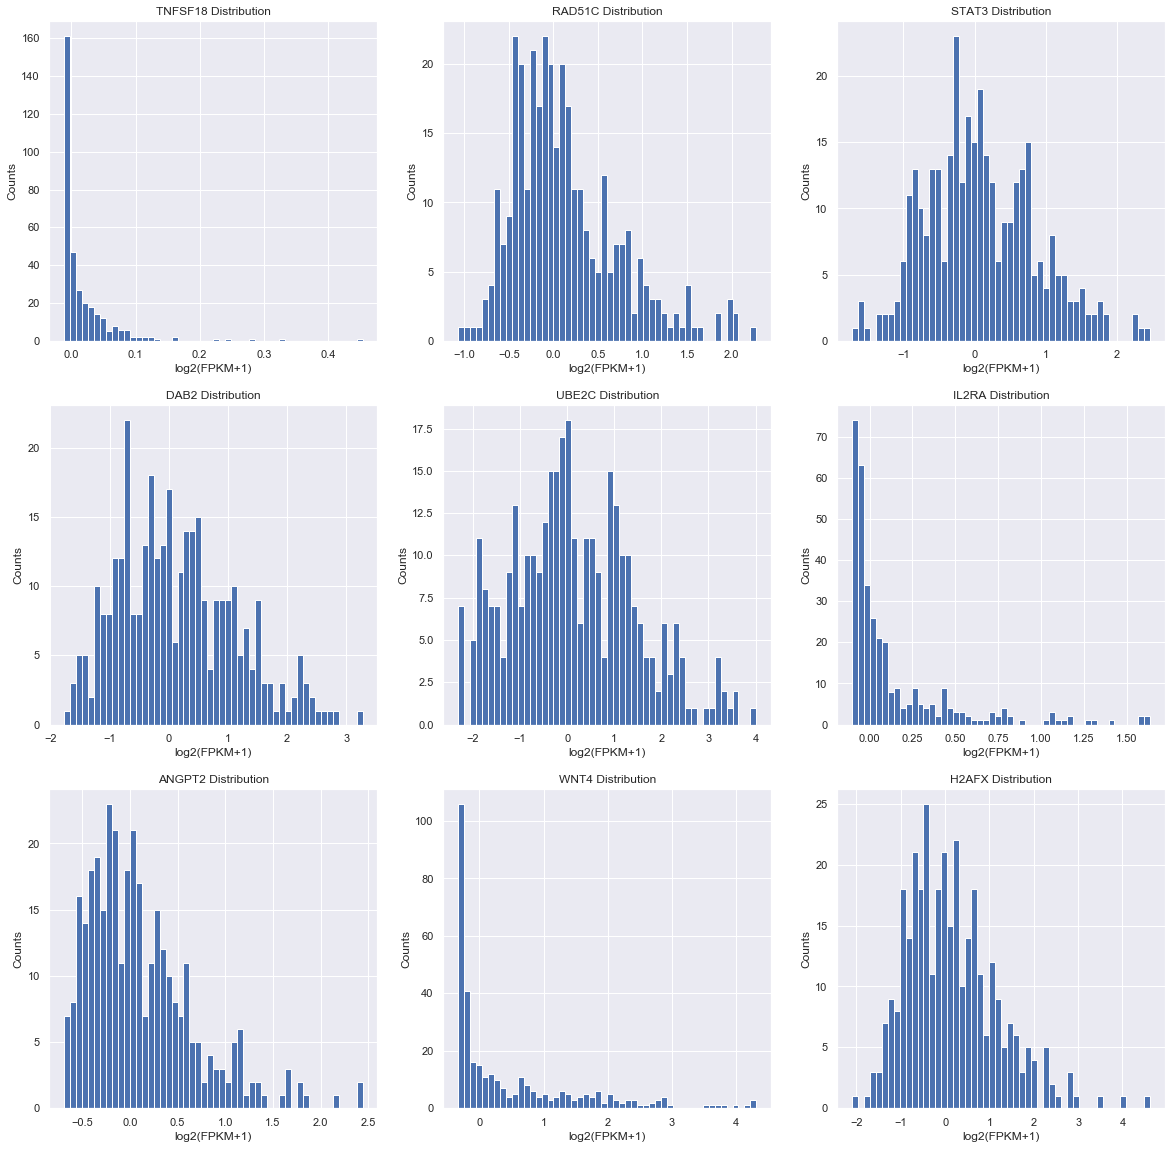

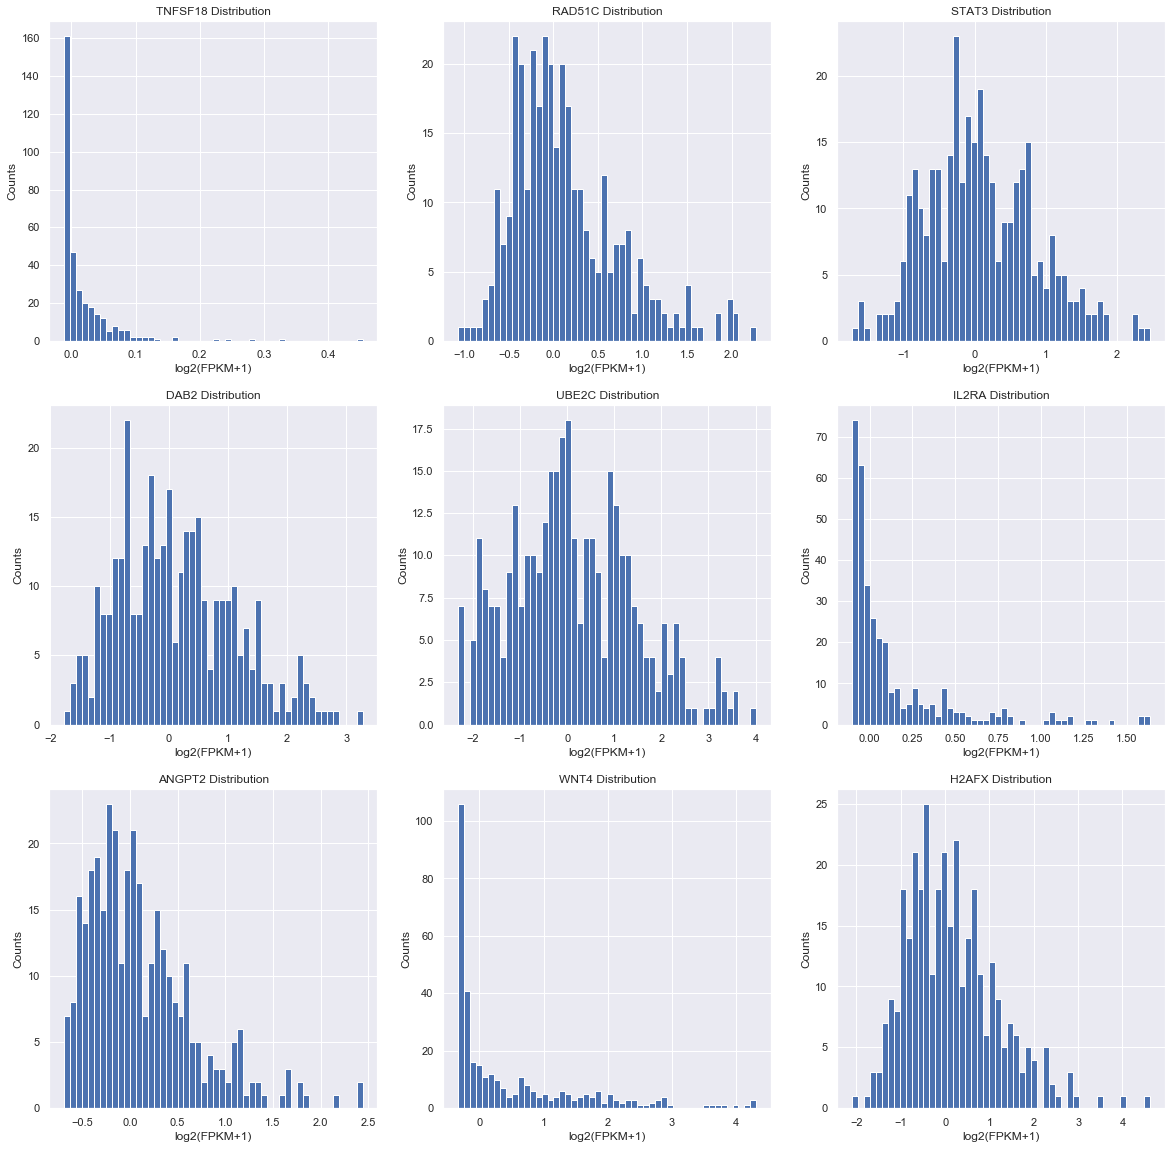

In [25]:
draw_histograms_per_gene(transform_data(data_full, centering="median", series = 'mondor'))

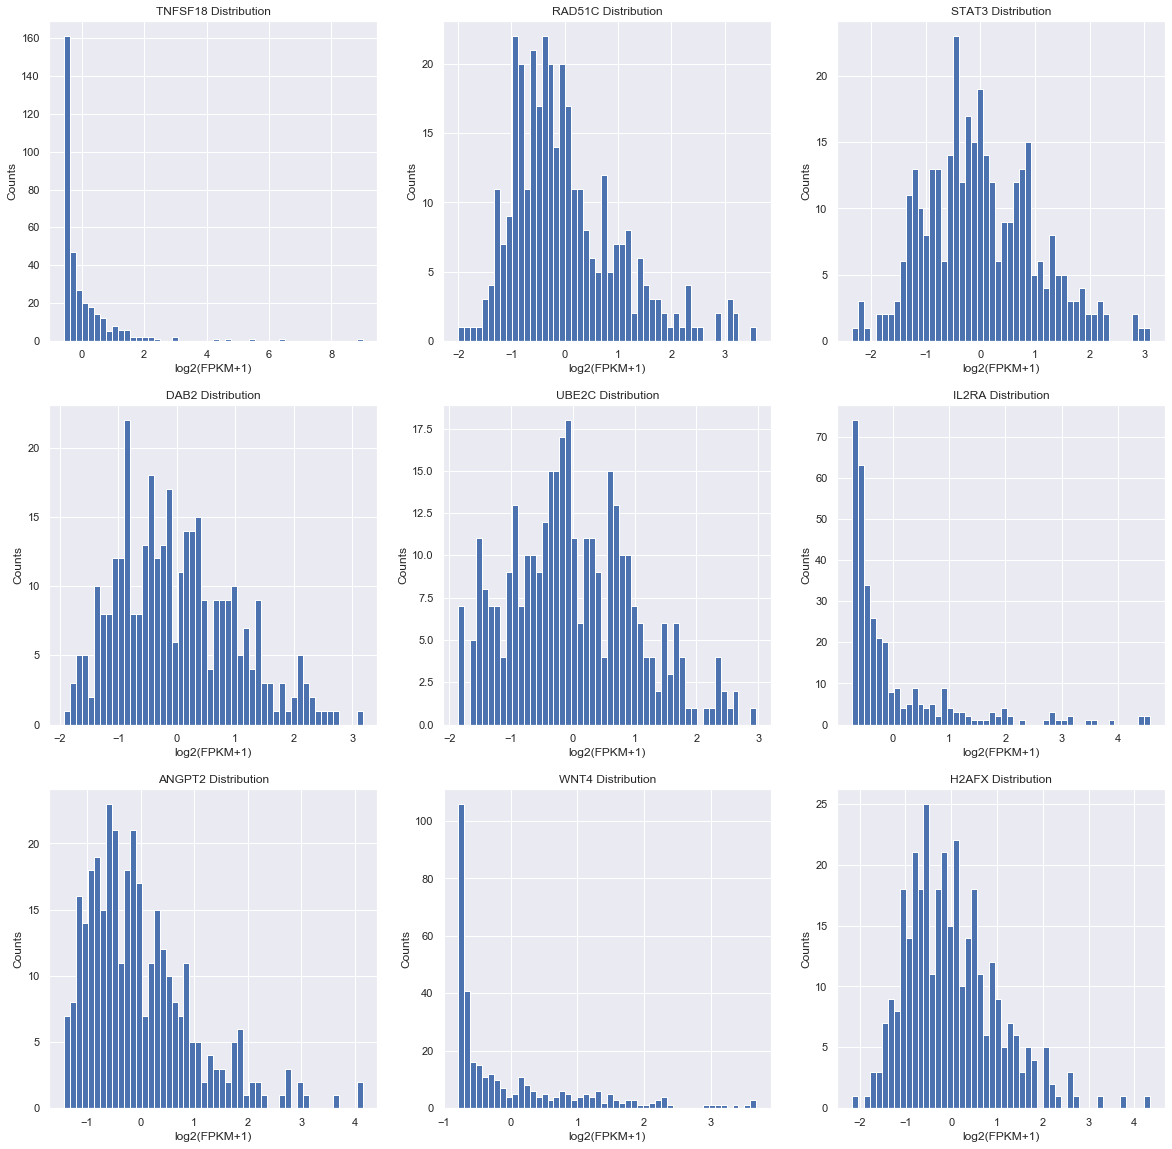

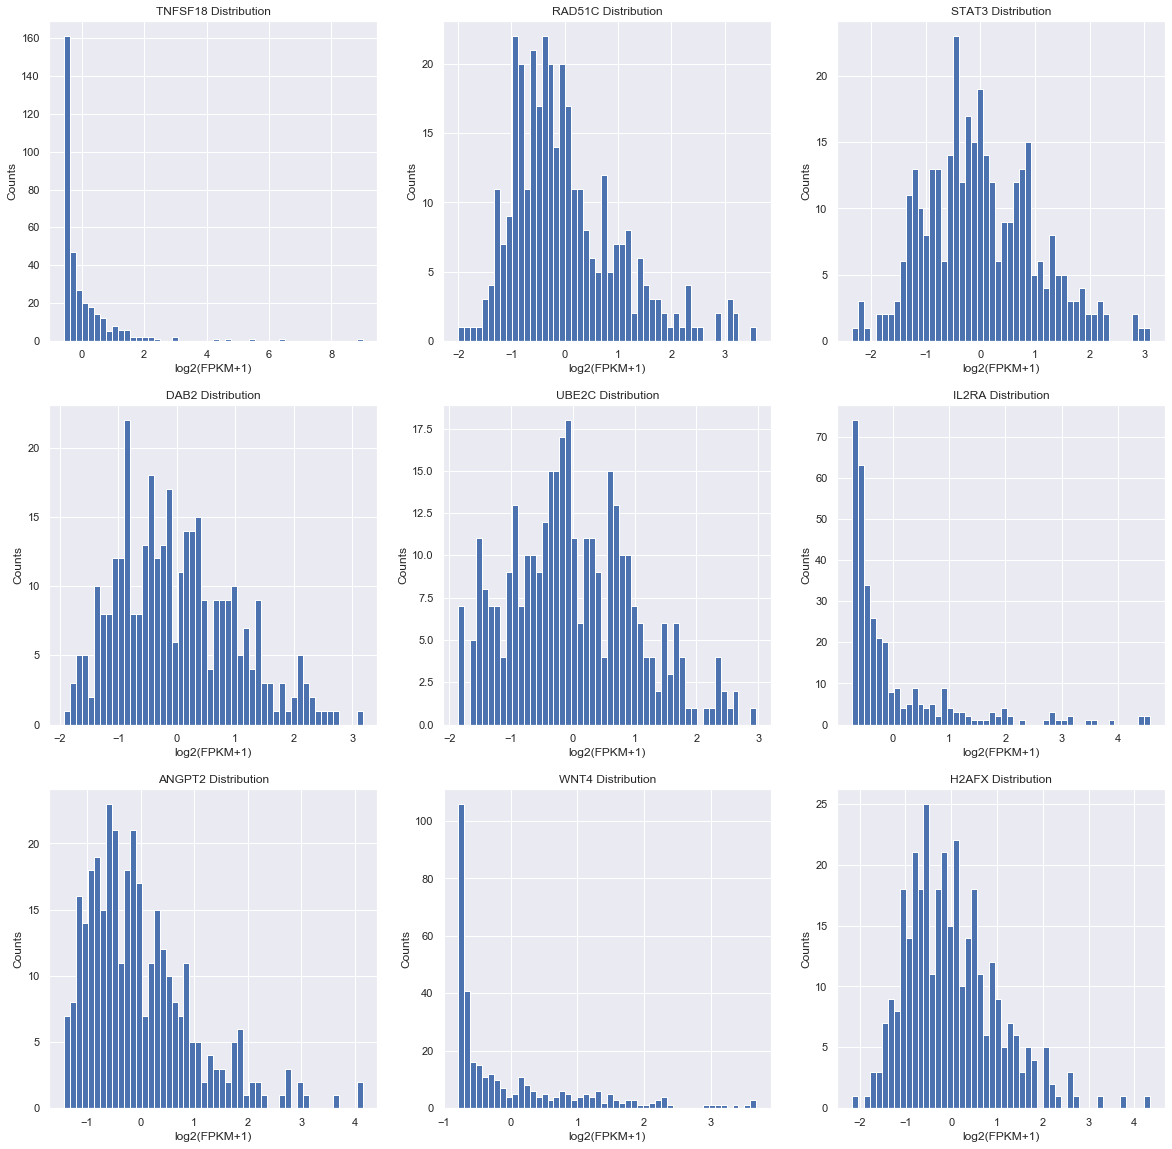

In [26]:
draw_histograms_per_gene(transform_data(data_full, centering="zscore", series = 'mondor'))

In [46]:
print(data_full.shape)
transform_data(data_full, centering="zscore", series = 'mondor').to_csv(os.path.join(root, 'heatmap_nanostring_155/mondor_final_log2-zscore-centering.csv'), index=True, sep='\t')

(747, 155)


In [101]:
transform_data(df=data_sia, centering="zscore", series = 'mondor').to_csv(root + 'processed\\fpkm_final_filtered-Sia_log2-zscore.csv', index=True, sep='\t')

In [42]:
transform_data(data_full.drop(data_filtered_6.index), centering="median", series = 'mondor').to_csv(root + 'processed\\fpkm_removed-6_log2-median-centering.csv', index=True, sep='\t')

## Subset with the same genes in TCGA SD > 4

In [68]:
df_tcga = pd.read_csv(os.path.join('/media/visiopharm5/WDGold/deeplearning/Hepatocarcinomes/TCGA', 'processed/fpkm_filtered-4_raw.csv'), index_col=0, sep='\t')
print(df_tcga.shape) # (331, 340)
display(df_tcga.head(5))

(331, 340)


,A3CH-01A,AAV2-01A,AACJ-01A,A3CI-01A,A9H2-01A,A1ED-01A,AADW-01A,A4ND-01A,A25X-01A,A7MB-01A,...,A75V-01A,A86L-01A,A9FV-01A,A216-01A,A9H8-01A,AADS-01A,A9GS-01A,A8TG-01A,A5KG-01A,AAV0-01A
Gene Name,,,,,,,,,,,,,,,,,,,,,
A2M,353.263484,71.666180,482.975256,2650.894063,14.251211,138.784253,189.289993,88.221089,581.340176,198.407439,...,483.048511,88.473934,76.677252,341.071423,28.873339,310.137116,99.827773,141.338309,95.612844,382.269582
ADM,4.417336,6.755378,2.370133,3.832422,1.599409,11.551210,1.149260,6.015631,10.934903,1.504026,...,1.648389,1.498936,6.070088,4.561270,1.914784,6.861121,1.534958,6.882283,1.177097,4.692262
AKT1,10.306615,10.086696,4.502617,16.103599,4.032345,9.311685,5.520715,7.323641,4.583061,3.714906,...,9.722378,13.070086,15.633574,17.381259,15.856656,15.134796,6.153513,8.740533,4.795359,30.614164
ALDOA,24.973960,36.716979,71.424500,63.396617,78.434536,22.994129,11.933247,15.711461,110.161900,21.343506,...,75.583841,21.663652,184.221570,30.610041,24.600406,138.468493,23.697205,25.654728,22.059109,71.763109
ALDOC,18.294094,0.187657,113.209141,75.151527,1.201148,12.475212,5.124611,16.639422,2.659073,23.062413,...,19.595239,80.981242,1.513710,12.525640,44.601327,22.529910,8.442518,17.238804,4.492481,89.778951


In [69]:
data_selected = data_full[data_full.index.isin(df_tcga.index.values.tolist())]
print(data_selected.shape) # (331, 139)
display(data_selected.head(5))

(331, 155)


,EX128-ARN189,EX128-ARN190,EX128-ARN191,EX128-ARN192,EX128-ARN193,EX128-ARN194,EX128-ARN195,EX128-ARN196,EX128-ARN197,EX128-ARN198,...,EX128-ARN337,EX128-ARN338,EX128-ARN339,EX128-ARN340,EX128-ARN341,EX128-ARN342,EX128-ARN343,EX128-ARN345,EX128-ARN346,EX128-ARN347
Gene Name,,,,,,,,,,,,,,,,,,,,,
A2M,4301.220,17983.246,15483.546,5113.288,4250.480,22340.941,7798.648,4416.493,3322.068,6040.628,...,2305.100,8090.045,10301.013,14885.443,40962.395,3889.948,18862.059,6113.576,30052.156,19756.762
ADM,195.771,149.628,96.486,77.397,107.820,97.619,125.270,198.764,39.293,98.465,...,73.804,83.723,98.923,160.625,82.913,76.924,274.587,41.946,139.917,116.130
AKT1,843.034,1664.486,825.685,1242.370,600.174,1333.054,687.763,836.711,1368.680,1148.660,...,401.777,546.115,1016.352,595.921,980.718,681.124,777.547,1091.746,1792.736,2025.454
ALDOA,2756.033,2410.943,2811.270,1657.607,3310.338,969.135,4962.696,1840.798,2021.177,2115.242,...,531.176,1454.916,942.487,486.292,635.070,866.716,808.265,6302.375,8376.747,1858.364
ALDOC,34.879,47.743,317.594,127.517,185.219,165.570,87.567,336.289,179.532,175.618,...,370.223,339.433,418.262,365.163,45.212,89.079,155.422,1263.190,445.515,157.228


In [70]:
data_selected.to_csv(os.path.join(root, 'heatmap_nanostring/mondor_final_selected_raw.csv'), index=True, sep='\t')

In [71]:
transform_data(data_selected, centering="zscore", series = 'mondor').to_csv(os.path.join(root, 'heatmap_nanostring/mondor_final_selected_log2-zscore-centering.csv'), index=True, sep='\t')